## 0. Importar series

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90

In [2]:
data_folder = './data/housing/'
csv_file = os.path.join(data_folder, "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

df_housing = pd.read_csv(csv_file)
df_housing.head(5)

RegionID  SizeRank                          RegionName RegionType  \
0    102001         0                       United States    Country   
1    394913         1                        New York, NY        Msa   
2    753899         2  Los Angeles-Long Beach-Anaheim, CA        Msa   
3    394463         3                         Chicago, IL        Msa   
4    394514         4               Dallas-Fort Worth, TX        Msa   

  StateName  2000-01-31  2000-02-29  2000-03-31  2000-04-30  2000-05-31  ...  \
0       NaN    127202.0    127546.0    127908.0    128645.0    129389.0  ...   
1        NY    224341.0    225681.0    226887.0    229261.0    231472.0  ...   
2        CA    231193.0    231998.0    233231.0    235576.0    238089.0  ...   
3        IL    170104.0    170505.0    171024.0    172064.0    173166.0  ...   
4        TX    130035.0    130139.0    130225.0    130437.0    130658.0  ...   

   2021-01-31  2021-02-28  2021-03-31  2021-04-30  2021-05-31  2021-06-30  \
0    271623.0    274979.0    278635.0    282495.0    287202.0    292730.0   
1    516687.0    521426.0    525792.0    530533.0    536044.0    543211.0   
2    741209.0    748698.0    756569.0    767615.0    783282.0    803090.0   
3    258211.0    260534.0    262648.0    265690.0    268442.0    272263.0   
4    276637.0    280005.0    284015.0    289524.0    295921.0    303225.0   

   2021-07-31  2021-08-31  2021-09-30  2021-10-31  
0    298613.0    304008.0    308632.0    312728.0  
1    551142.0    558738.0    564641.0    569191.0  
2    823992.0    837437.0    846549.0    851308.0  
3    276430.0    280547.0    283620.0    286280.0  
4    311010.0    318887.0    326057.0    332118.0  

[5 rows x 267 columns]

<AxesSubplot:>

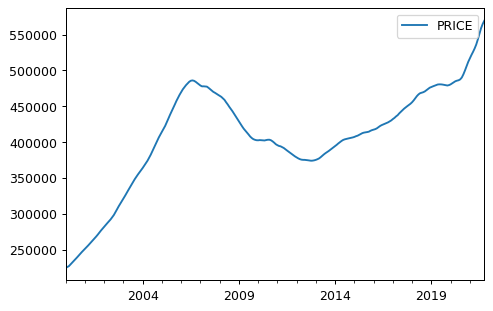

In [3]:

#Escogiendo el registro de NewYork (registro 1)
city_name = df_housing.iloc[1,2]
df_city = df_housing.iloc[1,5:].transpose()
df_city = pd.DataFrame(df_city).rename({1:"PRICE"}, axis=1)
df_city.index = pd.to_datetime(df_city.index)
df_city.loc[:,"PRICE"] = pd.to_numeric(df_city.loc[:,"PRICE"])
df_city.plot()

In [4]:
# Ejemplo ciudad seleccionada
print(df_city.describe())

               PRICE
count     262.000000
mean   407734.969466
std     72811.114203
min    224341.000000
25%    377385.250000
50%    411803.000000
75%    465953.250000
max    569191.000000


In [5]:
print(df_city.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2000-01-31 to 2021-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   262 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB
None


In [6]:
def matplot(series, x_label, y_label, title=None, size=[12,5], show=True):
    fig, ax = plt.subplots()
    g =series.plot(ax=ax)
    fig.set_size_inches(size)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    if title: ax.set_title(title)
    if show: plt.show()
    return ax

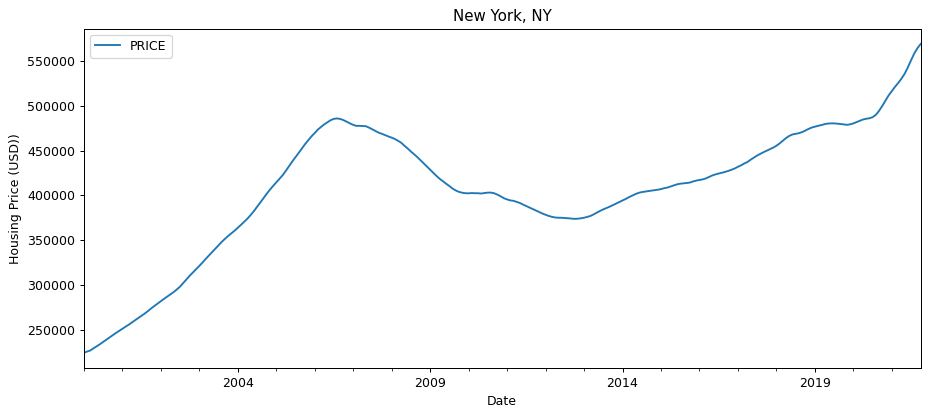

<AxesSubplot:title={'center':'New York, NY'}, xlabel='Date', ylabel='Housing Price (USD))'>

In [7]:
#Generamos la serie a partide de Fecha y Valor

price_series = df_city
series_name = city_name

#Ploteo de la serie
matplot(price_series,
        x_label="Date",
        y_label="Housing Price (USD))",
        title=series_name)

## 1. Setteando el env y Darts

In [8]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## 2. Creating a Training/Validation Series

The series will contain information up to 2014, leaving almost 5 years to validate the prediction

In [10]:
# rename the rainfall series to just series
series = TimeSeries.from_dataframe(price_series)

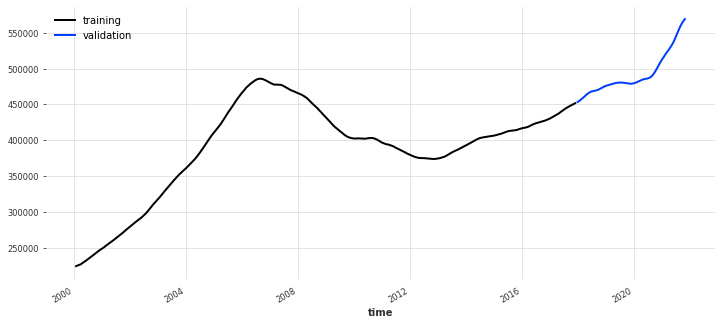

In [11]:
#train/
train, val = series.split_before(pd.Timestamp('20180101'))
fig, ax = plt.subplots()
train.plot(label='training', ax= ax)
val.plot(label='validation', ax=ax)
fig.set_size_inches([12,5])
plt.legend();
plt.show()

## 3. Forecasting

### Exploring Seasonality

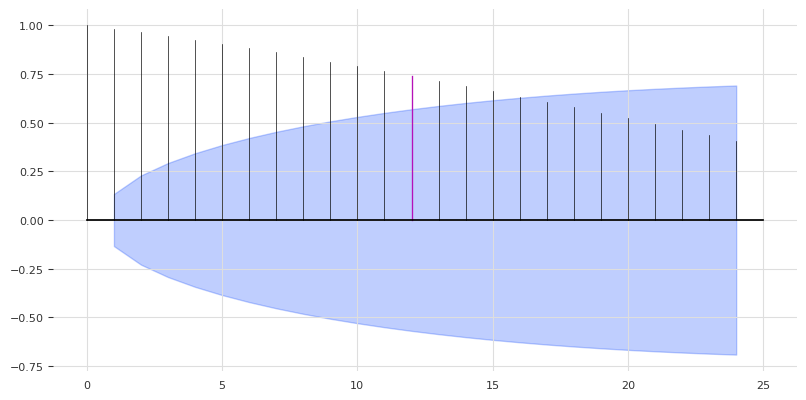

In [12]:
mpl.rcParams['figure.dpi'] = 96
plot_acf(train, m = 12, alpha = .05)

In [13]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

### Naive models

#### Naive Model (repeats)

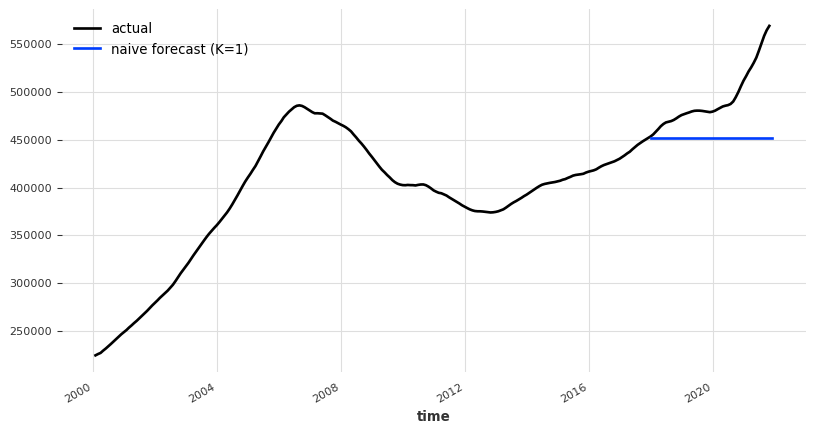

In [14]:
mpl.rcParams['figure.dpi'] = 96
mpl.rcParams['figure.figsize'] = [10,5]
k = 1 # simple repeat of last value
n_periods = 48 #months e.g. 4 years
naive_model = NaiveSeasonal(K=k)
naive_model.fit(train)
naive_forecast = naive_model.predict(n_periods)

series.plot(label='actual')
naive_forecast.plot(label=f'naive forecast (K={k})')
plt.legend();

#### Naive Model (seasonality)

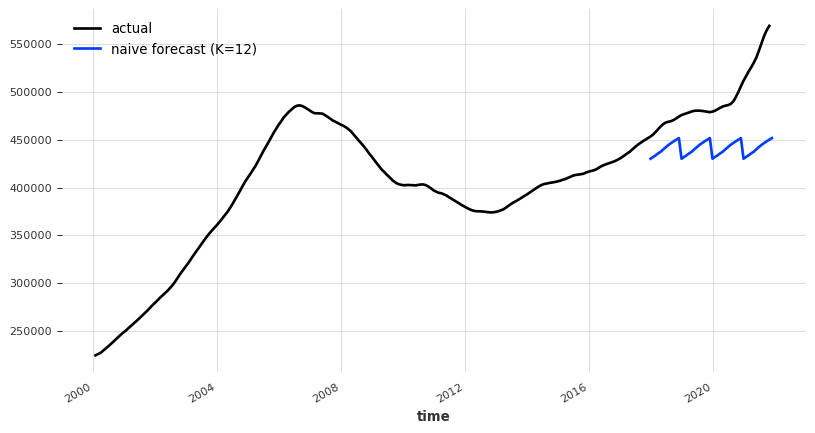

In [15]:
k = 12 # sesonality
n_periods = 48 #months e.g. 4 years

seasonal_model = NaiveSeasonal(K=k)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(n_periods)

series.plot(label='actual')
seasonal_forecast.plot(label=f'naive forecast (K={k})')
plt.legend();

#### Naive Drift

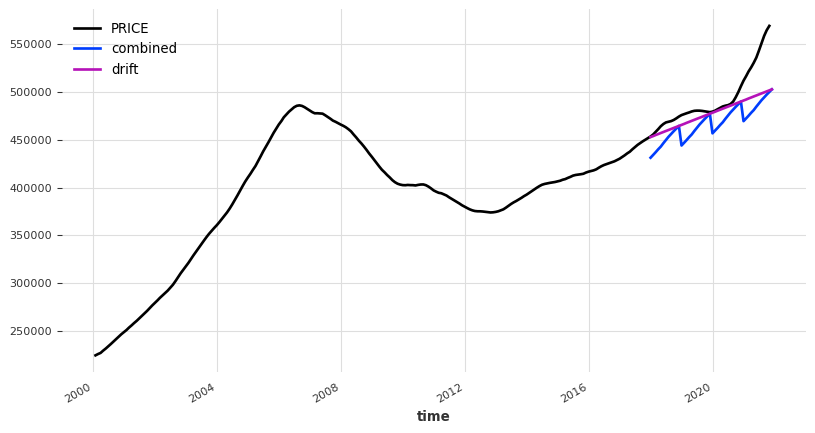

In [16]:
k = 12 # sesonality
n_periods = 48 #months e.g. 4 years

drift_model = NaiveDrift()
drift_model.fit(train)

drift_forecast = drift_model.predict(n_periods)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

In [17]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(abs(series), combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 5.05%.


### Non-Naive Models

**Models:** 
* Exponential Smoothing
* Prophet
* AutoARIMA
* Theta

In [18]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 1.89%
model Prophet obtains MAPE: 3.95%
model Auto-ARIMA obtains MAPE: 1.87%
model Theta(2) obtains MAPE: 6.45%


#### Theta Model

In [19]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [20]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 1.92, with theta = -0.6530612244897966.


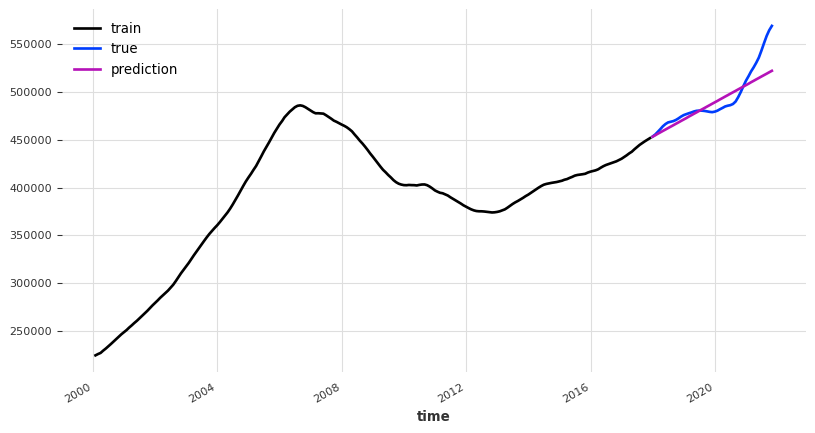

In [21]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();

##### Backtesting

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 1.4630775917655137
Median error (MAPE) over all historical forecasts: 0.7424057417035725


  0%|          | 0/128 [00:00<?, ?it/s]

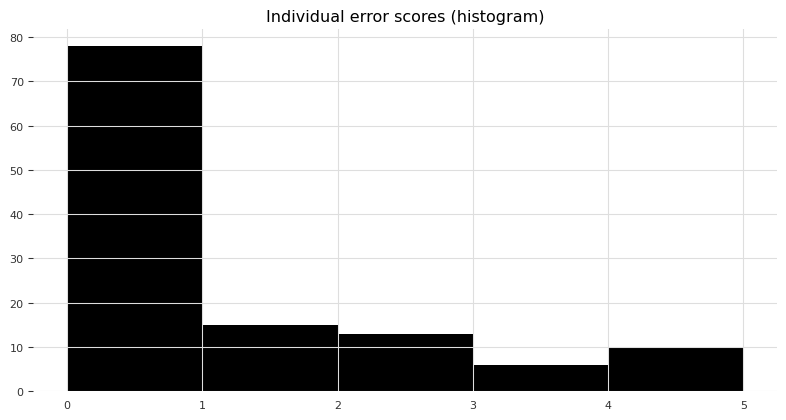

  0%|          | 0/128 [00:00<?, ?it/s]

In [22]:
best_theta_model = Theta(best_theta)

ini_timestamp_string = '2010-10-31'
forecast_horizon = 6 #Numero de meses para hacer el backtesting

average_error = best_theta_model.backtest(series, start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, verbose=True)
median_error = best_theta_model.backtest(series, start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, reduction=np.median, verbose=True)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))
print("Median error (MAPE) over all historical forecasts: {}".format(median_error))

raw_errors = best_theta_model.backtest(series, start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, reduction=None, verbose=True)
plt.hist(raw_errors, bins=np.arange(0, max(raw_errors), 1))
plt.title("Individual error scores (histogram)")
plt.show()

historical_fcast_theta = best_theta_model.historical_forecasts(series, start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, verbose=True)

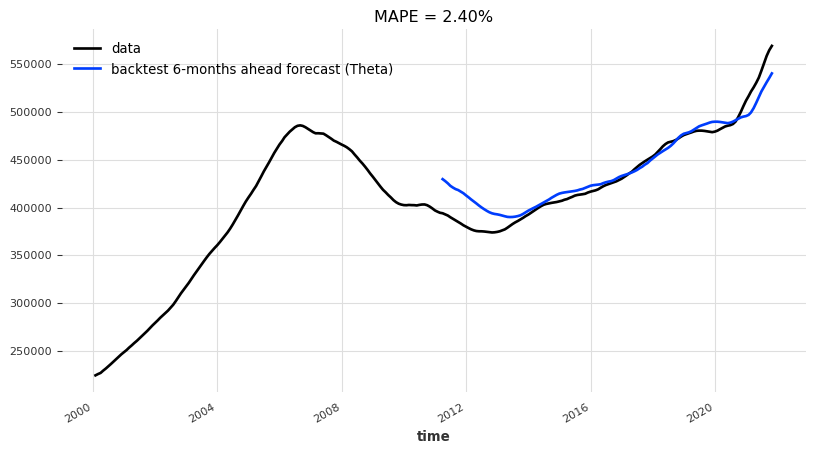

In [23]:
series.plot(label='data')
historical_fcast_theta.plot(label=f'backtest {forecast_horizon}-months ahead forecast (Theta)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
plt.legend();

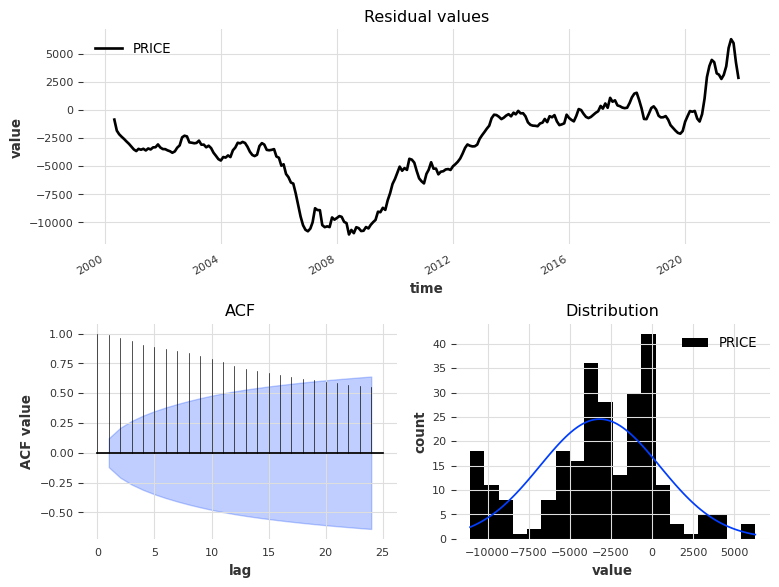

In [24]:
plot_residuals_analysis(best_theta_model.residuals(series))

#### Exponential smothing

  0%|          | 0/128 [00:00<?, ?it/s]

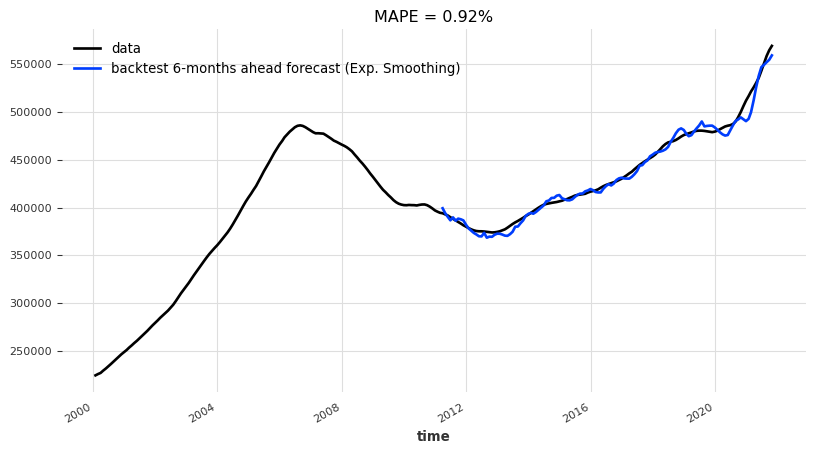

In [25]:
model_es = ExponentialSmoothing()
ini_timestamp_string = '2010-10-31'
forecast_horizon = 6

historical_fcast_es = model_es.historical_forecasts(series, start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, verbose=True)

series.plot(label='data')
historical_fcast_es.plot(label=f'backtest {forecast_horizon}-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
plt.legend()
plt.show()

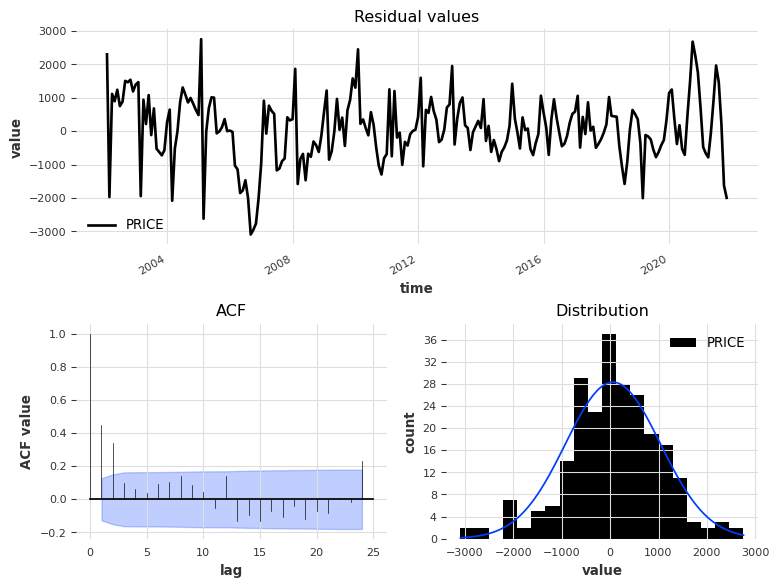

In [26]:
plot_residuals_analysis(model_es.residuals(series))


### Probabilistic forecast

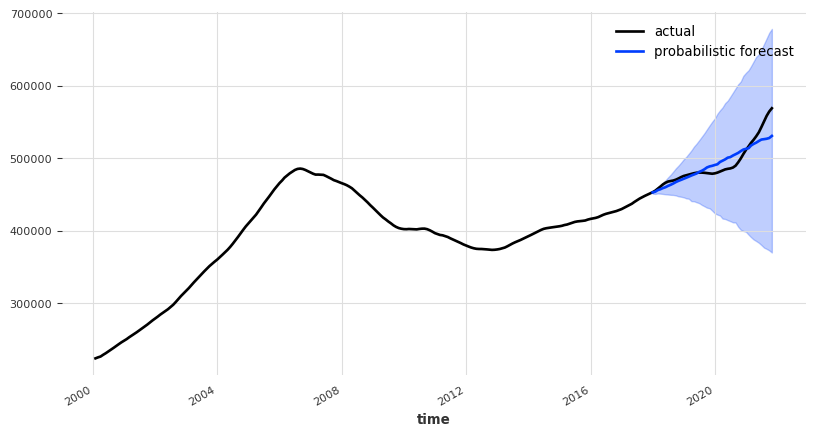

In [27]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label='actual')
probabilistic_forecast.plot(label='probabilistic forecast')
plt.legend()
plt.show()

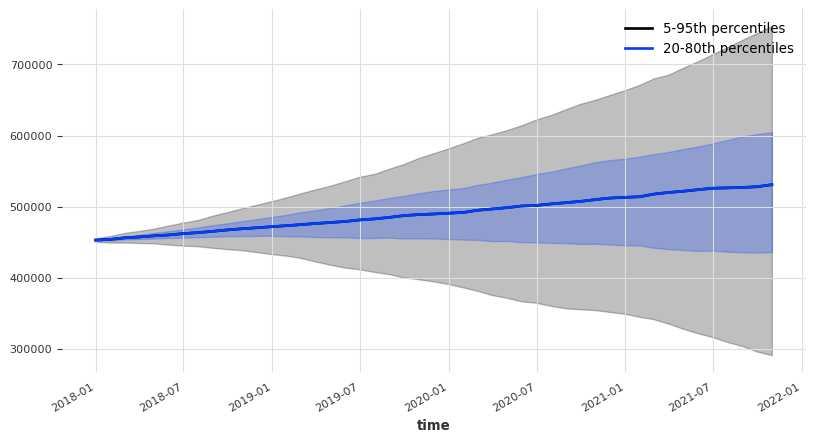

In [28]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label='5-95th percentiles')
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label='20-80th percentiles')

### Ensamble models

#### Regression approach

In [29]:
k1 = 6
k2 = 12
models = [NaiveSeasonal(k1), NaiveSeasonal(k2), NaiveDrift()]

model_predictions = [m.historical_forecasts(series, 
                                            start=pd.Timestamp('2010-01-31'), 
                                            forecast_horizon=12, 
                                            stride=12, 
                                            last_points_only=False,
                                            verbose=True)
                     for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [30]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

In [31]:

ini_timestamp_string = '2018-01-31'
forecast_horizon = 6 # meses
""" We build the regression model, and tell it to use the current predictions
"""
regr_model = RegressionModel(lags=None, lags_future_covariates=[0])

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
ensemble_pred = regr_model.historical_forecasts(
    series=series_target, future_covariates=model_predictions_stacked, 
    start=pd.Timestamp(ini_timestamp_string), forecast_horizon=forecast_horizon, verbose=True
)

  0%|          | 0/31 [00:00<?, ?it/s]


Regression coefficients for the individual models:
Learned coefficient for Naive seasonal model, with K=6: 0.39
Learned coefficient for Naive seasonal model, with K=12: -0.34
Learned coefficient for Naive drift model: 1.00


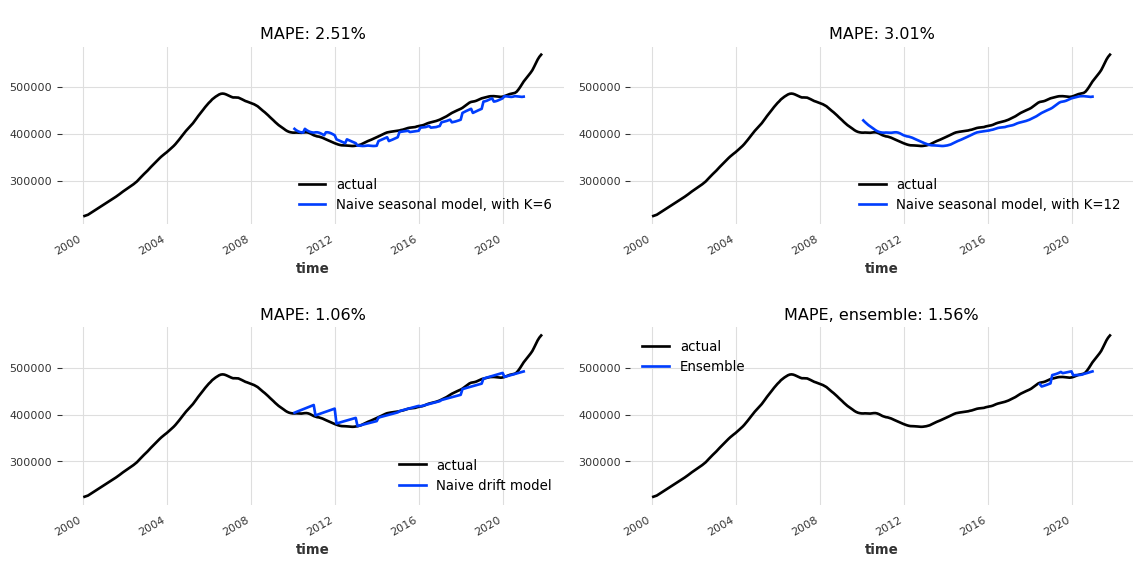

In [32]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])

    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)

    mape_model = mape(series, model_pred)
    ax[i].set_title('\nMAPE: {:.2f}%'.format(mape_model))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nMAPE, ensemble: {:.2f}%'.format(mape(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout();

Ensamble object approach

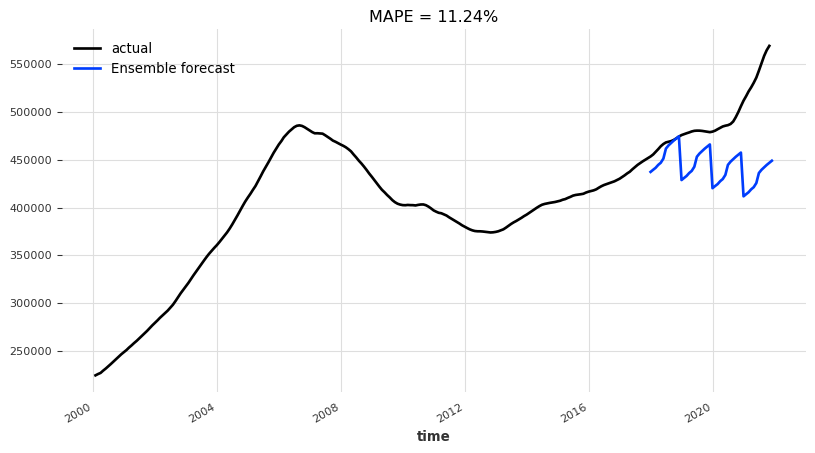

In [33]:

prediction_horizon = 48 #months
k = 6

ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(k1), NaiveSeasonal(k2), NaiveDrift()],
    regression_train_n_points=12)

ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(prediction_horizon)

series.plot(label='actual')
ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, series)))
plt.legend();

  0%|          | 0/137 [00:00<?, ?it/s]

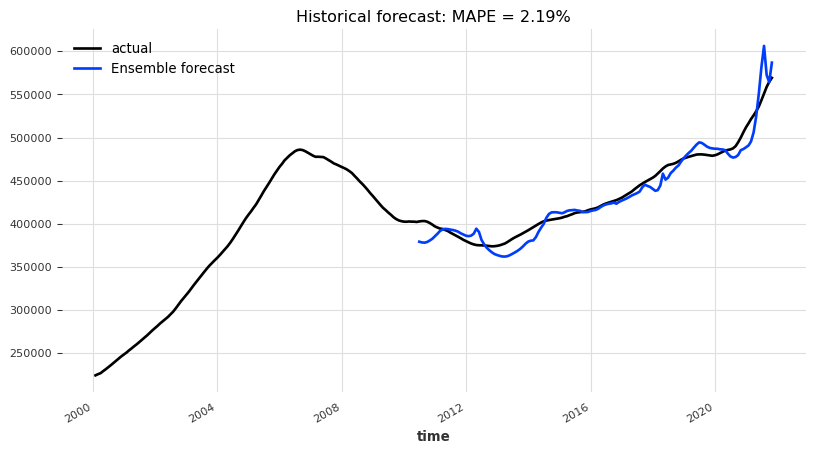

In [34]:
ensemble_pred_hist = ensemble_model.historical_forecasts(series,
                                                    start=pd.Timestamp('2010-01-31'),
                                                    forecast_horizon=forecast_horizon,
                                                    verbose=True)
series.plot(label='actual')
ensemble_pred_hist.plot(label='Ensemble forecast')
plt.title('Historical forecast: MAPE = {:.2f}%'.format(mape(ensemble_pred_hist, series)))
plt.legend();

# Multi-time series

In [35]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

torch.manual_seed(1); np.random.seed(1)  # for reproducibility

In [36]:
db_trusted = pd.read_excel(r"./data/trusted/Housing Data.xlsx", parse_dates=["Date"])
rainfall_series = db_trusted.query('StateName == "NY"')[["Date","RAIN_MM"]].set_index("Date")

rainfall_series = TimeSeries.from_dataframe(rainfall_series)
price_series = TimeSeries.from_dataframe(price_series)

In [37]:
rainfall_series.describe()

component     RAIN_MM
count      261.000000
mean        10.482901
std          6.292077
min          0.000000
25%          6.604000
50%          9.753600
75%         13.258800
max         48.133000

In [38]:
scaler_prices, scaler_rainfall = Scaler(), Scaler()
series_prices_scaled = scaler_prices.fit_transform(price_series)
series_rainfall_scaled = scaler_rainfall.fit_transform(rainfall_series)

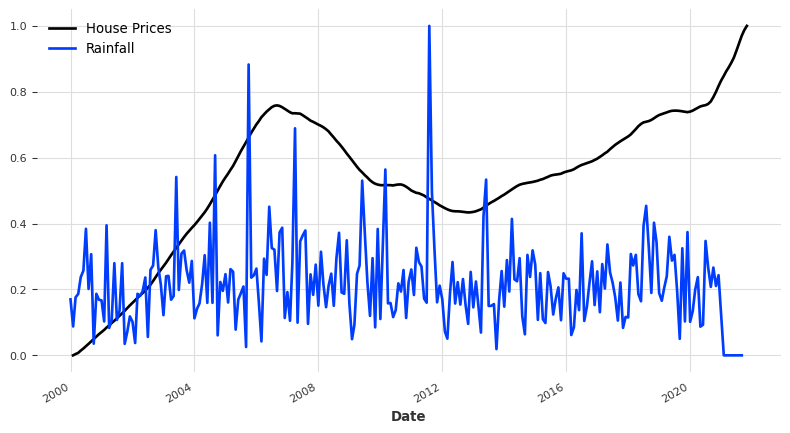

In [39]:
series_prices_scaled.plot(label='House Prices')
series_rainfall_scaled.plot(label='Rainfall')
plt.legend();

### Train test validation split

In [40]:
horizon_val= 36 # months
train_prices, val_prices = series_prices_scaled[:-horizon_val], series_prices_scaled [-horizon_val:]
train_rainfall, val_rainfall = series_rainfall_scaled[:-horizon_val], series_rainfall_scaled[-horizon_val:]

### Global Forecasting

In [41]:

model_prices = NBEATSModel( input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)
model_prices.fit(train_prices, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:

pred = model_prices.predict(n=horizon_val)

series_prices_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_prices_scaled, pred)))

### Training model with rainfall

In [ ]:
model_prices_rainfall = NBEATSModel( input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

In [ ]:
model_prices_rainfall.fit([train_prices, train_rainfall], verbose=True)

In [ ]:
#Haciendo la predicción al final de la serie
pred = model_prices_rainfall.predict(n=36, series=train_prices)

series_prices_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_prices_scaled, pred)))

### Covariates Series

In [ ]:
# build year and month series:
prices_year = datetime_attribute_timeseries(series_prices_scaled, attribute='year')
prices_month = datetime_attribute_timeseries(series_prices_scaled, attribute='month')

rainfall_year = datetime_attribute_timeseries(series_rainfall_scaled, attribute='year')
rainfall_month = datetime_attribute_timeseries(series_rainfall_scaled, attribute='month')

# stack year and month to obtain series of 2 dimensions (year and month):
prices_covariates = prices_year.stack(prices_month)
rainfall_covariates = rainfall_year.stack(rainfall_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
prices_covariates = scaler_dt_air.fit_transform(prices_covariates)

scaler_dt_milk = Scaler()
rainfall_covariates = scaler_dt_milk.fit_transform(rainfall_covariates)

# split in train/validation sets:
prices_train_covariates, prices_val_covariates = prices_covariates[:-36], prices_covariates[-36:]
rainfall_train_covariates, rainfall_val_covariates = rainfall_covariates[:-36], rainfall_covariates[-36:]

# plot the covariates:
plt.figure();
prices_covariates.plot();
plt.title('Housing prices (year and month)');

plt.figure();
rainfall_covariates.plot();
plt.title('Rainfall covariates (year and month)');

In [ ]:
model_cov = BlockRNNModel(model='LSTM', input_chunk_length=24, output_chunk_length=12, n_epochs=300, random_state=0)

In [ ]:
model_cov.fit(series=[train_prices, train_rainfall], 
              past_covariates=[prices_train_covariates, rainfall_train_covariates],
              verbose=True)

In [ ]:
pred_cov = model_cov.predict(n=36, 
                             series=train_prices, 
                             past_covariates=prices_covariates)

series_prices_scaled.plot(label='actual')
pred_cov.plot(label='forecast')
plt.legend();

**backtesting**

In [ ]:
backtest_cov = model_cov.historical_forecasts(series_prices_scaled,
                                              past_covariates=prices_covariates,
                                              start=0.6,
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_prices_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_prices_scaled, backtest_cov)))